# Using YOLO to predict Traffic Signs

## Install Dependencies

In [1]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.4/898.4 kB 3.0 MB/s eta 0:00:00


## Import Dependencies

In [2]:
import os,yaml, shutil,PIL
from pathlib import Path
from tqdm.auto import tqdm
from sklearn import model_selection
import xml.etree.ElementTree as ET
from PIL import Image
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# https://www.kaggle.com/datasets/andrewmvd/road-sign-detection

Mounted at /content/drive


## Preprocessing

In [ ]:
# This function converts the XML annotations into a python dictionary
def xml_to_dict(xml_file):
    root = ET.parse(xml_file).getroot()

    info_dict = {
        'filename': root.findtext("filename"),
        'image_size': tuple(int(subelem.text) for subelem in root.find("size")),
        'bboxes': []
    }

    for obj in root.findall("object"):
        bbox = {
            "class": obj.findtext("name"),
            "xmin": int(obj.find("bndbox/xmin").text),
            "ymin": int(obj.find("bndbox/ymin").text),
            "xmax": int(obj.find("bndbox/xmax").text),
            "ymax": int(obj.find("bndbox/ymax").text)
        }
        info_dict['bboxes'].append(bbox)

    return info_dict

In [5]:
# import the data
BASE_DIR = Path()

INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/street_sign'

In [6]:
# specifiy classes
class_name_to_id_mapping = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3
}

In [7]:
ANNOTATION_DIR = Path(INPUT_DIR).joinpath("annotations")

In [8]:
info_dict = xml_to_dict(ANNOTATION_DIR.joinpath("road1.xml"))
info_dict

{'filename': 'road1.png',
 'image_size': (400, 283, 3),
 'bboxes': [{'class': 'trafficlight',
   'xmin': 154,
   'ymin': 63,
   'xmax': 258,
   'ymax': 281}]}

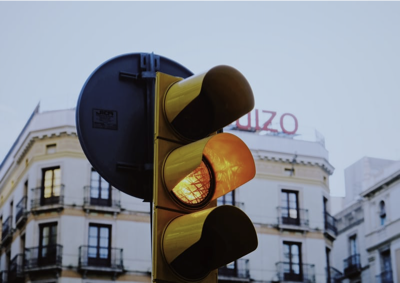

In [9]:
# preview the image
PIL.Image.open(str(INPUT_DIR)+"/images/road1.png")

In [ ]:
# prepare the dataset
def dataset(dataset_path):
    images_folder = dataset_path / 'images'
    annotations_folder = dataset_path / 'annotations'

    image_file_paths = [
        str(images_folder / image_file) for image_file in os.listdir(images_folder)
    ]

    annotation_data = []
    for image_path in tqdm(image_file_paths):
        img = Image.open(image_path)
        img_width, img_height = img.size
        annotation_file_path = annotations_folder / f"{Path(image_path).stem}.xml"

        # Convert XML annotations to YOLO format
        annotation_dict = xml_to_dict(annotation_file_path)
        formatted_annotations = [
            [
                class_name_to_id_mapping[bbox['class']],
                (bbox["xmin"] + bbox["xmax"]) / 2 / img_width,
                (bbox["ymin"] + bbox["ymax"]) / 2 / img_height,
                (bbox["xmax"] - bbox["xmin"]) / img_width,
                (bbox["ymax"] - bbox["ymin"]) / img_height
            ]
            for bbox in annotation_dict['bboxes']
        ]
        annotation_data.append(formatted_annotations)

    return image_file_paths, annotation_data

In [11]:
iPath, lPath = dataset(Path(INPUT_DIR))

  0%|          | 0/877 [00:00<?, ?it/s]

In [12]:
iPath[:2], lPath[:2]

(['/content/drive/MyDrive/Colab Notebooks/street_sign/images/road109.png',
  '/content/drive/MyDrive/Colab Notebooks/street_sign/images/road100.png'],
 [[[2, 0.64875, 0.5056179775280899, 0.0825, 0.11235955056179775]],
  [[2, 0.4975, 0.42987012987012985, 0.82, 0.8337662337662337]]])

## Split Test / Train

In [13]:
train_images, test_images, train_annotations, test_annotations = model_selection.train_test_split(
    iPath, lPath, test_size=0.2, random_state=42
)

In [14]:
print("# of Training Samples is: " , len(train_images), len(train_annotations))

print("# of Testing Samples is: " , len(test_images), len(test_annotations))

# of Training Samples is:  701 701
# of Testing Samples is:  176 176


In [15]:
!rm -rf clean_data
!mkdir clean_data
!mkdir clean_data/train
!mkdir clean_data/test

!mkdir clean_data/test/images clean_data/test/labels
!mkdir clean_data/train/images clean_data/train/labels

In [16]:
def setup_folders(img_paths, annot_paths, img_dest, annot_dest):
    for img_path, annots in tqdm(zip(img_paths, annot_paths), total=len(img_paths)):
        img = Image.open(img_path).convert("RGB")
        name = Path(img_path).stem

        # Save the image in PNG format and move to destination
        img_save_path = f"{name}.png"
        img.save(img_save_path)
        shutil.move(img_save_path, img_dest)

        # Write annotations to file
        with open(f'{annot_dest}/{name}.txt', 'w') as f:
            for annot in annots:
                f.write(' '.join(map(str, annot)) + '\n')

In [17]:
setup_folders(train_images,train_annotations,"clean_data/train/images","clean_data/train/labels")
setup_folders(test_images,test_annotations,"clean_data/test/images","clean_data/test/labels")

  0%|          | 0/701 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

In [18]:
dataset_dir = "clean_data"
output_dir = os.getcwd()

dict_file = {
    "train": os.path.join(dataset_dir, "train"),
    "val": os.path.join(dataset_dir, "test"),
    "nc": 4,
    "names": {0: "trafficlight",  1: "stop", 2: "speedlimit", 3: "crosswalk"},
}

with open(os.path.join(output_dir, "data.yaml"), "w+") as f:
    yaml.dump(dict_file, f)

## Model Configuration

In [ ]:
# Import the YAML file with the YOLO configurations 
def read_yaml_file(file_path=dataset_dir):
    with open(file_path, "r") as f:
        try:
            data = yaml.safe_load(f)
            return data
        except yaml.YAMLError as e:
            print(f"Error reading YAML: {e}")
            return None

def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(output_dir, "data.yaml")
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
  0: trafficlight
  1: stop
  2: speedlimit
  3: crosswalk
nc: 4
train: clean_data/train
val: clean_data/test



In [ ]:
# import the pre-trained YOLO v11 model
model =YOLO('yolo11n.pt')
model.info()


100%|██████████| 5.35M/5.35M [00:00<00:00, 67.9MB/s]


YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(319, 2624080, 0, 6.614336)

In [21]:
model.train(
    data=os.path.join(output_dir, 'data.yaml'),

    task='detect',

    imgsz=(512, 512),

    epochs=15,
    batch=8,
    optimizer='Adam',
    patience=20,  # Early stopping patience (stop if no improvement)

    name=f'road_sign_detection_yolov8n',

    val=False,      # Enable validation during training
    amp=True,       # Enable automatic mixed precision for faster training
    exist_ok=True,  # Allows overwriting of existing output directory
    resume=False,   # Resume training from the last checkpoint
    device=0,       # GPU device to use (e.g., 0 for GPU 0, [0,1] for multi-GPU)

    save=True,      # Save model checkpoints and results
)



Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/data.yaml, epochs=15, time=None, patience=20, batch=8, imgsz=(512, 512), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=road_sign_detection_yolov8n, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 14.8MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/clean_data/train/labels... 701 images, 0 backgrounds, 0 corrupt: 100%|██████████| 701/701 [00:00<00:00, 1168.61it/s]

train: New cache created: /content/clean_data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/clean_data/test/labels... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 913.91it/s] 


val: New cache created: /content/clean_data/test/labels.cache
Plotting labels to runs/detect/road_sign_detection_yolov8n/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/road_sign_detection_yolov8n
Starting training for 15 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/15     0.914G      1.138      2.034      1.221         11        512: 100%|██████████| 88/88 [00:23<00:00,  3.82it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/15     0.833G      1.155      1.386      1.265          9        512: 100%|██████████| 88/88 [00:20<00:00,  4.20it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/15     0.822G      1.148      1.283      1.306         11        512: 100%|██████████| 88/88 [00:21<00:00,  4.11it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/15      0.83G      1.131      1.231      1.271         14        512: 100%|██████████| 88/88 [00:21<00:00,  4.15it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/15     0.822G      1.014      1.073      1.193         11        512: 100%|██████████| 88/88 [00:20<00:00,  4.37it/s]


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/15      0.83G     0.9593     0.9879      1.164          9        512: 100%|██████████| 88/88 [00:21<00:00,  4.07it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/15     0.822G     0.8875     0.8885      1.119          7        512: 100%|██████████| 88/88 [00:19<00:00,  4.40it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/15     0.822G     0.8625     0.8104      1.101          8        512: 100%|██████████| 88/88 [00:25<00:00,  3.43it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/15      0.83G     0.8218     0.7555      1.073          6        512: 100%|██████████| 88/88 [00:19<00:00,  4.54it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/15     0.822G     0.7834     0.6915      1.042          6        512: 100%|██████████| 88/88 [00:19<00:00,  4.54it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/15     0.822G     0.7729     0.6618      1.036          6        512: 100%|██████████| 88/88 [00:19<00:00,  4.56it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/15     0.822G     0.7601     0.6254      1.017          9        512: 100%|██████████| 88/88 [00:19<00:00,  4.43it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/15     0.822G     0.7411     0.6136      1.014          6        512: 100%|██████████| 88/88 [00:19<00:00,  4.59it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/15     0.822G     0.6898     0.5814     0.9808          6        512: 100%|██████████| 88/88 [00:19<00:00,  4.61it/s]



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/15     0.822G     0.6872      0.563     0.9844          6        512: 100%|██████████| 88/88 [00:18<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.47it/s]


                   all        176        236       0.88      0.776      0.846       0.69

15 epochs completed in 0.095 hours.
Optimizer stripped from runs/detect/road_sign_detection_yolov8n/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/road_sign_detection_yolov8n/weights/best.pt, 5.4MB

Validating runs/detect/road_sign_detection_yolov8n/weights/best.pt...
Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]


                   all        176        236       0.88      0.777      0.846       0.69
          trafficlight         18         25      0.732      0.437      0.579      0.355
                  stop         13         13      0.877      0.846      0.927      0.809
            speedlimit        137        157      0.959      0.994      0.989      0.885
             crosswalk         36         41      0.951      0.829       0.89      0.711
Speed: 0.5ms preprocess, 3.3ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/road_sign_detection_yolov8n


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79859e50da50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Results

In [42]:
metrics = model.val()

Ultralytics 8.3.43 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/clean_data/test/labels.cache... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]


                   all        176        236      0.885      0.796      0.848      0.692
          trafficlight         18         25      0.732      0.436      0.575      0.351
                  stop         13         13      0.898      0.923      0.939      0.818
            speedlimit        137        157       0.96      0.994      0.989      0.887
             crosswalk         36         41      0.952      0.829       0.89      0.711
Speed: 0.2ms preprocess, 4.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/road_sign_detection_yolov8n


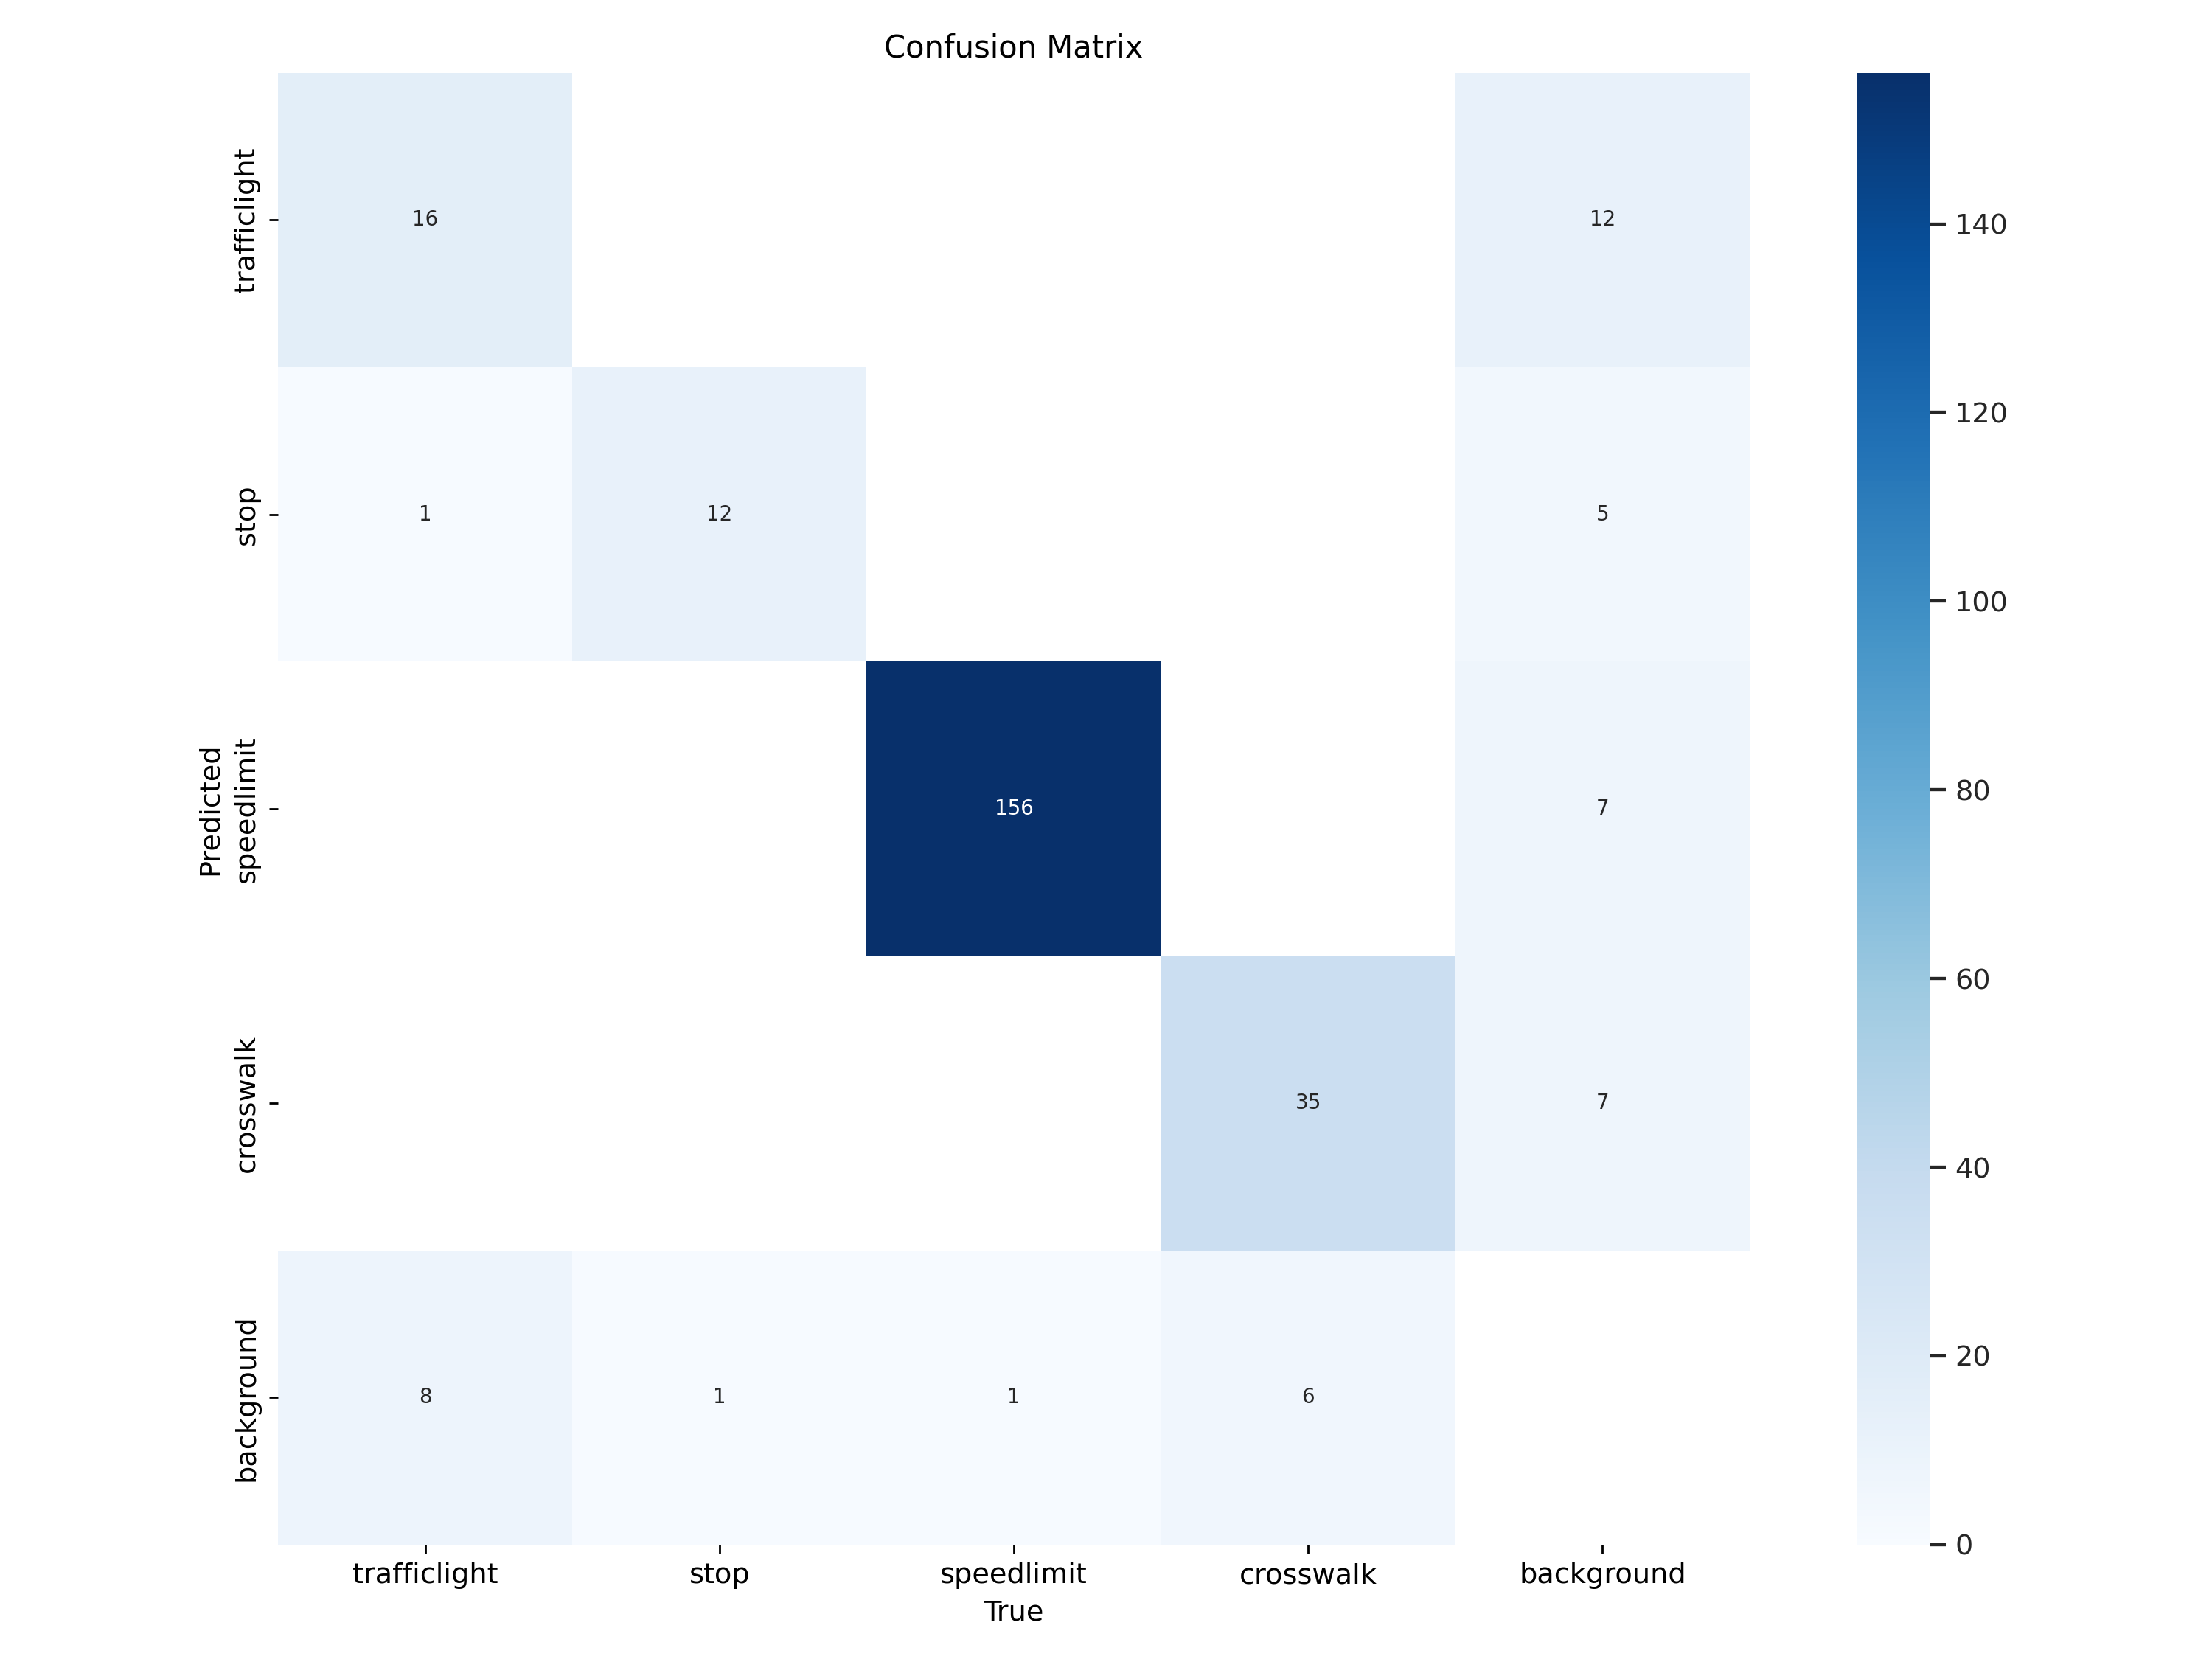

In [60]:
# Display the confusion matrix image
image_path = 'runs/detect/road_sign_detection_yolov8n/confusion_matrix.png'
Image(filename=image_path, width=800)

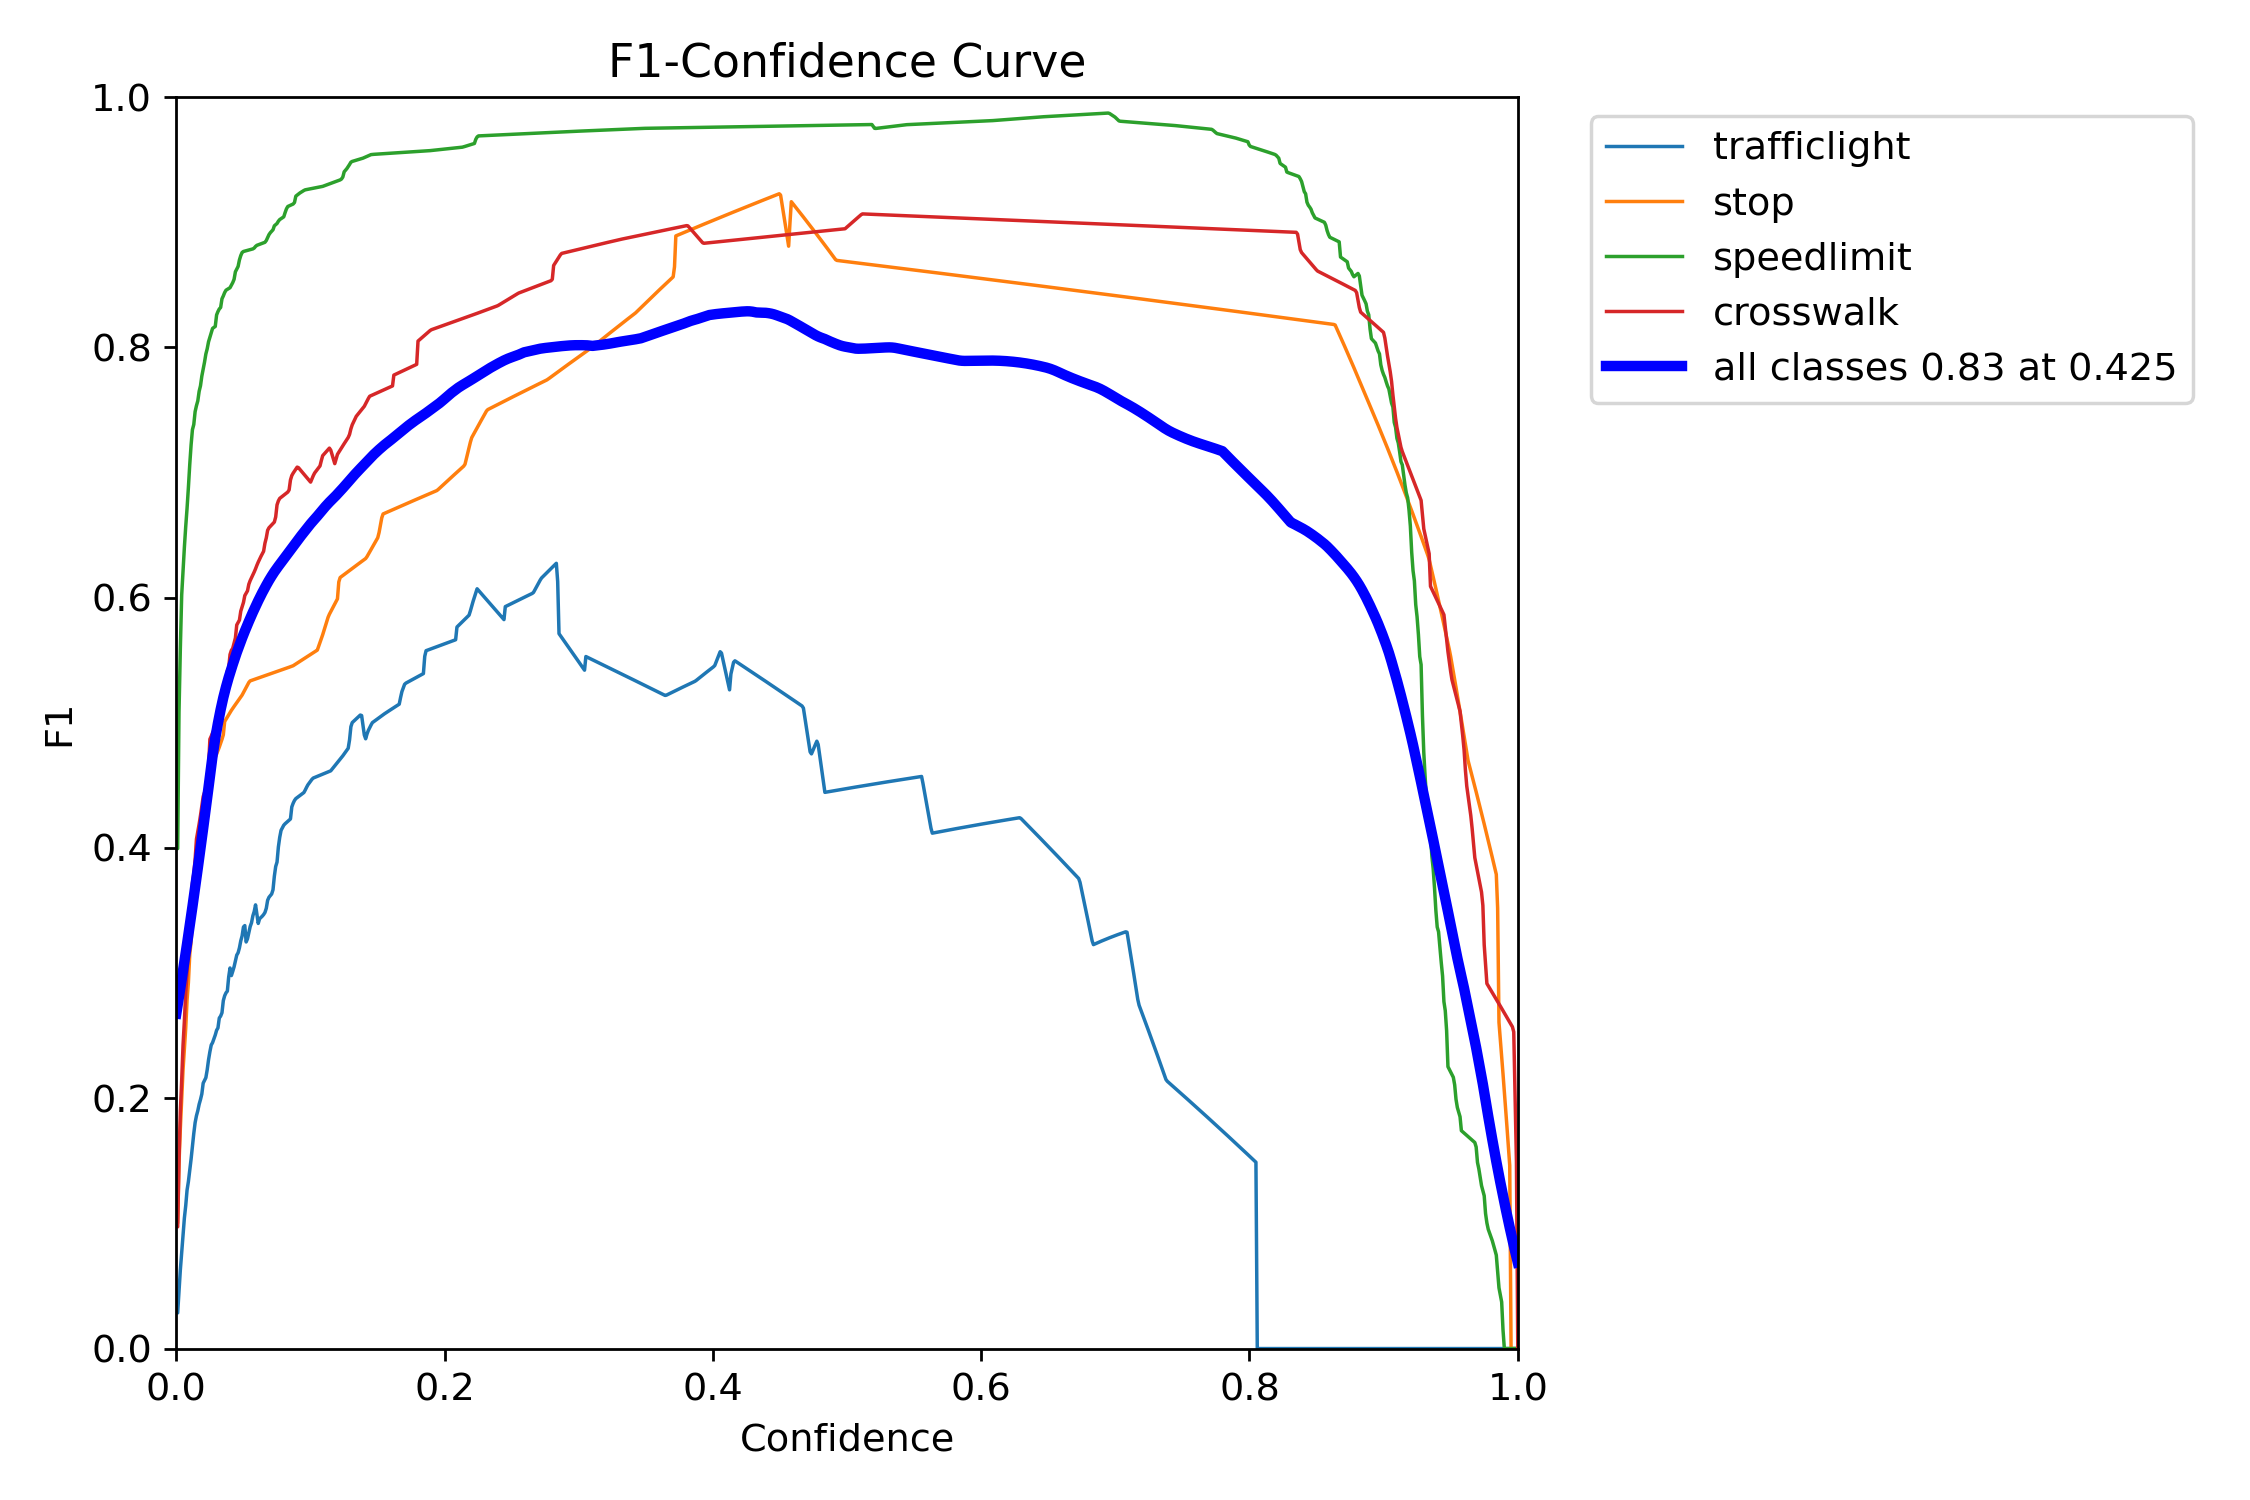

In [68]:
image_path = 'runs/detect/road_sign_detection_yolov8n/F1_curve.png'
Image(filename=image_path, width=800)

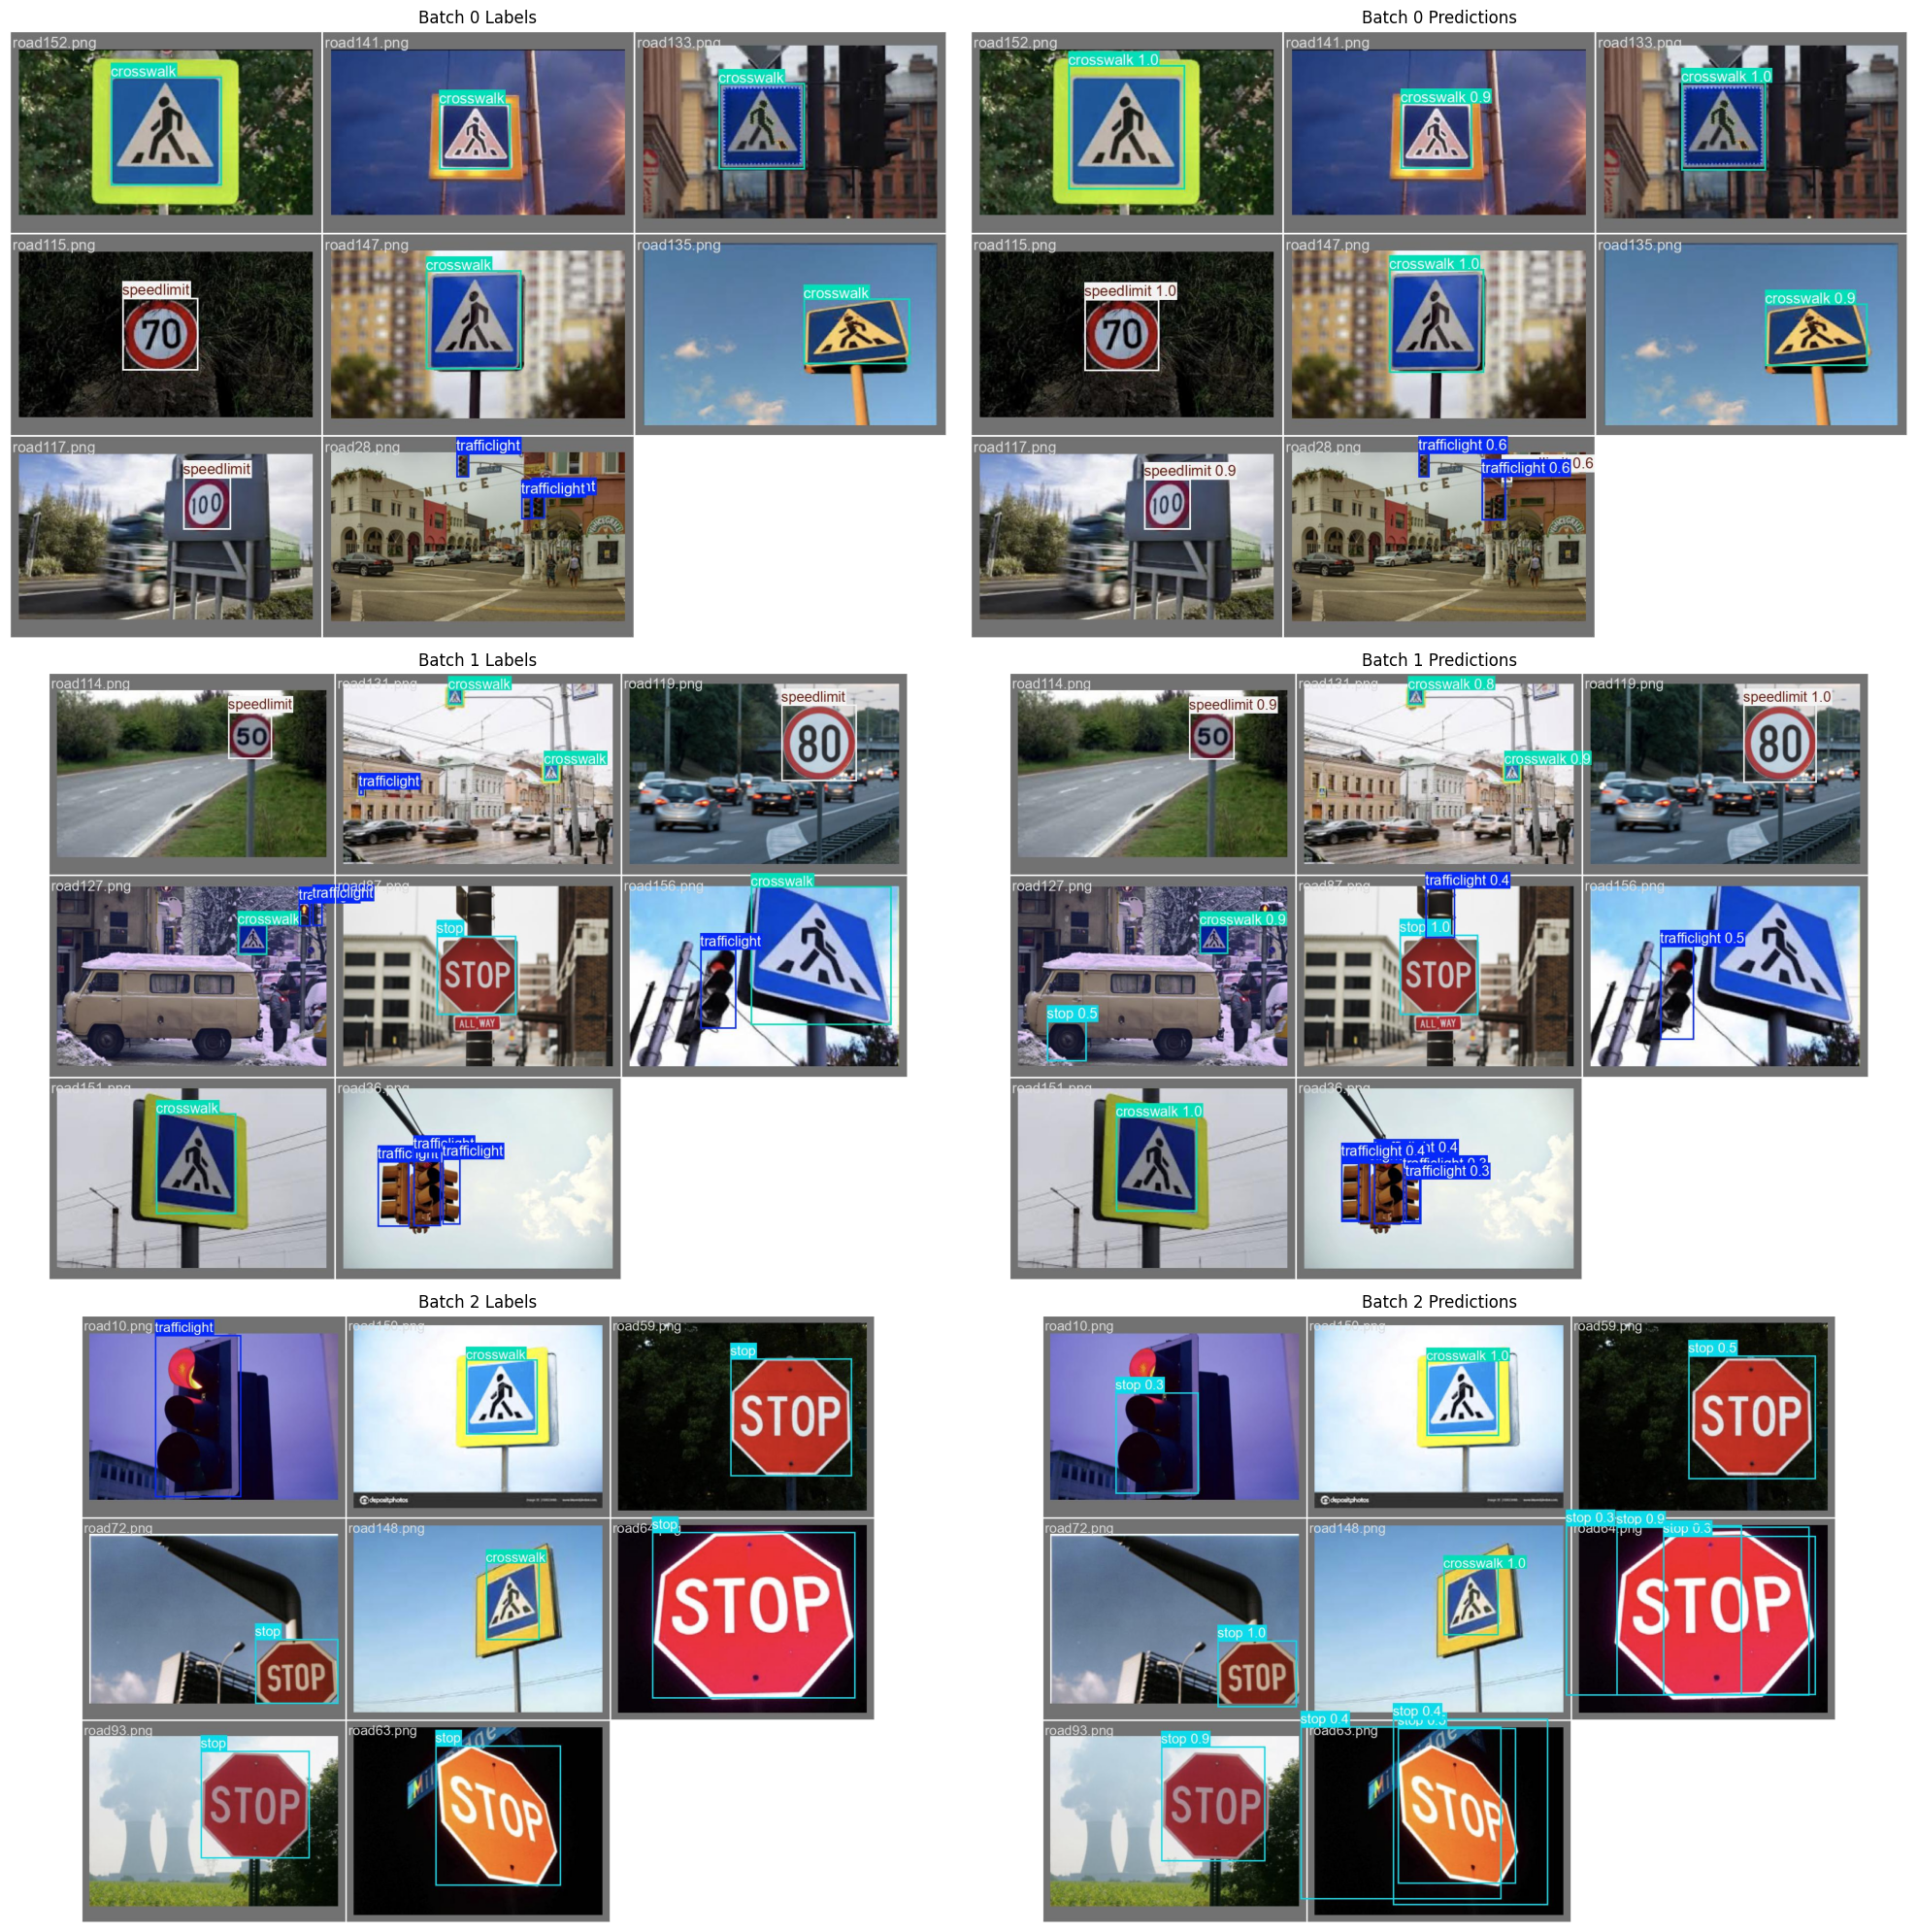

In [78]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# Ensure inline plotting for Jupyter Notebook
%matplotlib inline

# Set figure size (optional)
rcParams['figure.figsize'] = 20, 20

# Read images
img_A = mpimg.imread('runs/detect/road_sign_detection_yolov8n/val_batch0_labels.jpg')
img_A_pred = mpimg.imread('runs/detect/road_sign_detection_yolov8n/val_batch0_pred.jpg')

img_B = mpimg.imread('runs/detect/road_sign_detection_yolov8n/val_batch1_labels.jpg')
img_B_pred = mpimg.imread('runs/detect/road_sign_detection_yolov8n/val_batch1_pred.jpg')

img_C = mpimg.imread('runs/detect/road_sign_detection_yolov8n/val_batch2_labels.jpg')
img_C_pred = mpimg.imread('runs/detect/road_sign_detection_yolov8n/val_batch2_pred.jpg')

# Create subplots to arrange images in a grid
fig, axes = plt.subplots(3, 2)  # 3 rows, 2 columns

# Plot images in their respective positions
axes[0, 0].imshow(img_A)
axes[0, 0].set_title("Batch 0 Labels")
axes[0, 1].imshow(img_A_pred)
axes[0, 1].set_title("Batch 0 Predictions")

axes[1, 0].imshow(img_B)
axes[1, 0].set_title("Batch 1 Labels")
axes[1, 1].imshow(img_B_pred)
axes[1, 1].set_title("Batch 1 Predictions")

axes[2, 0].imshow(img_C)
axes[2, 0].set_title("Batch 2 Labels")
axes[2, 1].imshow(img_C_pred)
axes[2, 1].set_title("Batch 2 Predictions")

# Remove axes for a cleaner display
for ax in axes.flat:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [63]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!zip -r /runs.zip runs

updating: runs/ (stored 0%)
updating: runs/detect/ (stored 0%)
updating: runs/detect/road_sign_detection_yolov8n/ (stored 0%)
updating: runs/detect/road_sign_detection_yolov8n/train_batch2.jpg (deflated 5%)
updating: runs/detect/road_sign_detection_yolov8n/results.png (deflated 11%)
updating: runs/detect/road_sign_detection_yolov8n/train_batch442.jpg (deflated 12%)
updating: runs/detect/road_sign_detection_yolov8n/PR_curve.png (deflated 15%)
updating: runs/detect/road_sign_detection_yolov8n/results.csv (deflated 62%)
updating: runs/detect/road_sign_detection_yolov8n/train_batch1.jpg (deflated 5%)
updating: runs/detect/road_sign_detection_yolov8n/labels_correlogram.jpg (deflated 39%)
updating: runs/detect/road_sign_detection_yolov8n/confusion_matrix_normalized.png (deflated 26%)
updating: runs/detect/road_sign_detection_yolov8n/val_batch0_labels.jpg (deflated 15%)
updating: runs/detect/road_sign_detection_yolov8n/confusion_matrix.png (deflated 30%)
updating: runs/detect/road_sign_detect